# 2nd workbook

In [1]:
import pandas as pd
import numpy as np
import os 
import statsmodels.api as sm

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use("seaborn-whitegrid")
plt.rc(
    "figure",
    autolayout=True,
    figsize=(11, 4),
    titlesize=18,
    titleweight='bold',
)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)
%config InlineBackend.figure_format = 'retina'

pd.options.display.float_format = '{:,.2f}'.format

In [2]:
from importlib import reload

In [3]:
import wrangle as wr
import summaries as su
import model as m

### acquire .py

In [4]:
import pandas as pd
import numpy as np
import os

########### GLOBAL VARIABLES ###########


######## ACQUIRE FUNCTIONS #############

import pandas as pd
import numpy as np
import os

########### GLOBAL VARIABLES ###########


######## ACQUIRE FUNCTIONS #############

def acquire_data() -> pd.DataFrame:
    '''
    Reads the data from the csv file. 
    Filters data by the Vendor Name (Cisco)
    Renames columns by making them lower case replacing white space with underscore
    Removes columns where all values are NULL
    Saves the data into data.pickle file.
    Next interation reads the data from the saved file
    Returns: pandas DataFrame
    '''
    filename = 'data/data.pickle'
    filename_csv = 'data/OFFICIAL_DIR_Cooperative_Contract_Sales_Data___Fiscal_2010_To_Present.csv'
    if os.path.isfile(filename):
        # read the filtered data  
        df = pd.read_pickle(filename)
        return df
    # if not available, go to the file downloaded from https://data.texas.gov/
    # the full link to the site available in the Readme file
    else:
        try:
            # read the csv file with the data of all companies
            df1 = pd.read_csv(filename_csv, low_memory=False)
            # filter by Vendor Name is Cisco 
            df = df1[df1["Vendor Name"].str.contains('Cisco')].copy()
            # rename columns into programming friendly format
            # to lower case, white spaces replaced by underscore
            df.columns = df.columns.str.lower().str.replace(' ', '_')
            # drop the columns where all values are NULL
            df.drop(['staffing_contractor_name',
                'staffing_technology', 'staffing_title', 'staffing_level',
                'staffing_technology_type', 'staffing_start_date',
                'staffing_acquistion_type'], axis=1, inplace=True)
            # save the file
            pd.to_pickle(df, filepath_or_buffer=filename)
            return df
        except FileNotFoundError:
            # if file not found print:
            print('The file doesn\'t exist. Please, download it from the link provided in the Readme file')  

def basic_clean(df:pd.DataFrame, start2018=False) -> pd.DataFrame:
    '''
    Remove unneeded columns
    Create a copy of order date
    Changes dates type
    Sets order date as an index
    Parameters:
        df: pandas data frame
    Returns:
        cleaned data frame
    '''
    # list of columns to drop
    drop_columns = ['fiscal_year',
     'rfo_description',
     'rfo_number',
     'contract_number',
     'customer_contact',
     'customer_address',
     'customer_state',
     # 'customer_zip',
     'vendor_name',
     'vendor_contact',
     'vendor_hub_type',
     'vendor_address',
     'vendor_state',
     'vendor_city',
     'vendor_zip',
     'reseller_hub_type',
     'reseller_address',
     'reseller_state',
     'reseller_zip',
     'reseller_phone',
     'report_received_month',
     'brand_name',
     'purchase_month',
     'invoice_number',
     'dir_contract_mgr',
     'contract_type',
     'contract_subtype',
     'contract_start_date',
     'contract_end_date',
     'contract_termination_date',
     'sales_fact_number']

    df = df.drop(columns = drop_columns, axis=1)
    # create a copy for the shipped date
    df['order_date_copy'] = df.order_date

    # convert order date and shpping date to datetime
    df.order_date = pd.to_datetime(df.order_date)
    df.shipped_date = pd.to_datetime(df.shipped_date)
    df.order_date_copy = pd.to_datetime(df.order_date_copy)
    
    
    df = drop2017_and_move2016_up(df)
    
    # save the shipped date as index
    df = df.set_index('order_date').sort_index()

    if start2018:
    # data doesn't have enough info about 2017, so we starts from 2018
        df = df.loc['2018':]
    else:
        # keep all but drop 2017
        df = df.loc["2014":]
    return df

def drop2017_and_move2016_up(df):
    '''
    This function drops missing year 2017 to combine data with 2018+ dataframe. This is done by creating a temporary
    dataframe and adding a year to years 2014-2016 to creates a seam between 2016 and 2018. 
    return dataframe with new years for temp_df
    '''
    temp_df = df[(df.order_date.dt.year==2014)|(df.order_date.dt.year==2015)|(df.order_date.dt.year==2016)]
    temp_df['order_date'] = temp_df['order_date'] +  pd.offsets.DateOffset(years=1)
    
    temp2 = df[(df.order_date.dt.year==2018)|(df.order_date.dt.year==2019)|(df.order_date.dt.year==2020)|(df.order_date.dt.year==2021)|(df.order_date.dt.year==2022)]
    final_df = pd.concat([temp_df, temp2], axis =0)
    
    return final_df

def add_date_features(df):
    '''
    Add features based on the date:
    year, month, week number, week day in numerical and human readable values
    
    Parameters:
        df: pandas data frame with date as an index
    Return:
        df: pandas data frame with features added
    '''
    # numerical features
    df['year'] = df.index.year
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['week'] = df.index.isocalendar().week
    df['day_of_week'] = df.index.day_of_week
    df['day_of_year'] = df.index.day_of_year
    # month and day human readable
    df['month_name'] = df.index.month_name()
    df['day_name'] = df.index.day_name()
    
    return df

def change_customer_type(df):
    '''
    Replace low value count values with 'Other'
    Returns data frame with replaced values in customer type
    '''
    # remove 30 rows with the sales out of Texas
    df = df[df.customer_type != 'Out of State'].copy()
    # make assistance org other
    df.customer_type.replace({'Assistance Org':'Other'},inplace=True)
    
    return df

def change_column_order(df):
    '''
    change the order of columns
    '''
    columns_order = ['customer_name', 
                     'customer_type', 
                     'customer_city',
                     'reseller_name', 
                     'reseller_city',
                     'customer_zip',
                     'order_quantity', 
                     'unit_price',
                     'po_number', 
                     'shipped_date', 
                     'order_date_copy',
                     'month_name', 
                     'day_name',
                     'year',
                     'quarter',
                     'month', 
                     'week',
                     'day_of_week', 
                     'day_of_year',
                     'purchase_amount']
    return df[columns_order]

def get_clean_data(start2018=False):
    '''
    combines all functions from above
    '''
    df = acquire_data()
    df = basic_clean(df, start2018=start2018)
    df = add_date_features(df)
    df = change_customer_type(df)
    df = change_column_order(df)

    return df


def split_data(df, explore=True):
    '''
    splits the data frame based on date
    '''
    if explore:
        train = df.loc[:'2021']
        test = df.loc['2022']
        return train, test
    else:
        return df

In [ ]:
df = get_clean_data(start2018=True)

In [ ]:
df.groupby(lambda x: x.year).size()

In [ ]:
# 2018 + data frame
df.shape

In [ ]:
df["2018":].shape

In [ ]:
df['2018'].shape

In [ ]:
df['2019'].shape

In [ ]:
df['2020'].shape

In [ ]:
df['2021'].shape

In [ ]:
df['2022'].shape

In [ ]:
# from 2014 and on
df_all = get_clean_data(start2018=False)

In [ ]:
df_all.shape

In [ ]:
df_all['2022'].shape

In [ ]:
261886-372837

In [ ]:
372837-321680

In [ ]:
df.shape

### how to manage missing year 2017...

In [ ]:
df['2018'].max(), df['2018'].min()

Original 2016 max----------------------------
```python
(customer_name      Zapata County Public Library
 customer_type                      State Agency
 customer_city                            Zapata
 reseller_name                       Zones, Inc.
 reseller_city                      Vernon Hills
 order_quantity                       599,994.00
 unit_price                         1,346,270.33
 po_number                          ewscada09/16
 shipped_date                2020-04-30 00:00:00
 order_date_copy             2016-12-31 00:00:00
 month_name                            September
 day_name                              Wednesday
 year                                       2016
 quarter                                       4
 month                                        12
 week                                         53
 day_of_week                                   6
 day_of_year                                 366
 purchase_amount                    1,346,270.33
 dtype: object,
 
 
 Original 2016 min -----------------------------
 customer_name      Abilene Independent School District
 customer_type                                Higher Ed
 customer_city                                  Abilene
 reseller_name                               AT&T Corp.
 reseller_city                                  Addison
 order_quantity                               -9,000.00
 unit_price                                        0.00
 po_number                                   0000004241
 shipped_date                       2015-01-05 00:00:00
 order_date_copy                    2016-01-01 00:00:00
 month_name                                       April
 day_name                                        Friday
 year                                              2016
 quarter                                              1
 month                                                1
 week                                                 1
 day_of_week                                          0
 day_of_year                                          1
 purchase_amount                             -61,140.60
 dtype: object)
```

2018 max -------------------
``` python 
(customer_name      Zephyr Independent School District
 customer_type                            State Agency
 customer_city                                  Zephyr
 reseller_name                             Zones, Inc.
 order_quantity                           1,048,103.48
 unit_price                               1,130,443.51
 shipped_date                      2022-11-30 00:00:00
 order_date_copy                   2018-12-31 00:00:00
 month_name                                  September
 day_name                                    Wednesday
 year                                             2018
 quarter                                             4
 month                                              12
 week                                               52
 day_of_week                                         6
 day_of_year                                       365
 purchase_amount                          2,028,000.00
 dtype: object,
 
 2018 min ------------------------------------------
 customer_name      Abilene Independent School District
 customer_type                                Higher Ed
 customer_city                                   AUSTIN
 reseller_name                               AT&T Corp.
 order_quantity                             -799,867.61
 unit_price                                        0.00
 shipped_date                       2018-01-02 00:00:00
 order_date_copy                    2018-01-02 00:00:00
 month_name                                       April
 day_name                                        Friday
 year                                              2018
 quarter                                              1
 month                                                1
 week                                                 1
 day_of_week                                          0
 day_of_year                                          2
 purchase_amount                            -468,750.00
 dtype: object)
```

```python
Original
2014    20596 
2022    26361
2015    39198 two got added here from 2015 to 2016
2021    49931
2016    51157 four got added  her from 2016 to 2017
2018    55843  24 got added here? from 2018 to 2018
2019    63452
2020    66299
```

### create definition to handle missing year

In [ ]:
def drop2017_and_move2016_up(df):
    '''
    This function drops missing year 2017 to combine data with 2018+ dataframe. This is done by creating a temporary
    dataframe and adding a year to years 2014-2016 to creates a seam between 2016 and 2018. 
    return dataframe with new years for temp_df
    '''
    temp_df = df[(df.order_date.dt.year==2014)|(df.order_date.dt.year==2015)|(df.order_date.dt.year==2016)]
    temp_df['order_date'] = temp_df['order_date'] +  pd.offsets.DateOffset(years=1)
    
    temp2 = df[(df.order_date.dt.year==2018)|(df.order_date.dt.year==2019)|(df.order_date.dt.year==2020)|(df.order_date.dt.year==2021)|(df.order_date.dt.year==2022)]
    final_df = pd.concat([temp_df, temp2], axis =0)
    
    return final_df

In [7]:
def get_customer_summary(df: pd.DataFrame) -> pd.DataFrame:
    '''
    Creates a pandas data frame with the summary information for every customer:
    - total/min/max/average purchase amount
    - min/max order date
    - min/max shipped date
    
    Parameters:
        df: data frame with data from DIR
    Returns:
        pandas data frame
    '''
    # create a customer summury
    # collect the purchase amount information: total, min, max and average purchase amount
    customer_summary = df.groupby(by='customer_name').purchase_amount.agg(['sum', 'min', 'max', 'mean'])
    # rename columns
    customer_summary.rename(columns={'sum':'total_purchase_amount', 'min':'min_purchase_amount', 
                             'max':'max_purchase amount', 'mean':'average_purchase_amount'},inplace=True)
    # add order date information: first and last order date
    if 'order_date_copy' in df.columns:
        customer_summary = pd.concat([customer_summary,
                           df.groupby(by='customer_name').order_date_copy.agg(['min', 'max'])], axis=1)
    elif 'order_date' in df.columns:
        customer_summary = pd.concat([customer_summary,
                           df.groupby(by='customer_name').order_date.agg(['min', 'max'])], axis=1)        
    # rename columns
    customer_summary.rename(columns={'min':'min_order_date', 
                                 'max':'max_order_date'},inplace=True)
    # add shipping date information: first and last shipping date
    customer_summary = pd.concat([customer_summary,
                           df.groupby(by='customer_name').shipped_date.agg(['min', 'max'])], axis=1)
    # rename columns
    customer_summary.rename(columns={'min':'min_shipping_date', 
                                 'max':'max_shipping_date'},inplace=True)
    return customer_summary



In [8]:
df= get_clean_data(start2018=True)

In [9]:
# split data for modeling

In [10]:
train, test = wr.split_data(df)

In [11]:
train

,customer_name,customer_type,customer_city,reseller_name,reseller_city,customer_zip,order_quantity,unit_price,po_number,shipped_date,order_date_copy,month_name,day_name,year,quarter,month,week,day_of_week,day_of_year,purchase_amount
order_date,,,,,,,,,,,,,,,,,,,,
2018-01-02,San Benito Consolidated Independent School Dis...,K-12,San Benito,"Insight Public Sector, Inc.",Tempe,"78,586.00",1.00,63.36,191971,2018-02-03,2018-01-02,January,Tuesday,2018,1,1,1,1,2,63.36
2018-01-02,Princeton Independent School District,K-12,Princeton,CDW Government LLC,Vernon Hills,"75,407.00",41.00,659.56,JLVZ605,2018-01-02,2018-01-02,January,Tuesday,2018,1,1,1,1,2,"27,041.96"
2018-01-02,Princeton Independent School District,K-12,Princeton,CDW Government LLC,Vernon Hills,"75,407.00",55.00,571.56,JLVZ605,2018-01-02,2018-01-02,January,Tuesday,2018,1,1,1,1,2,"31,435.80"
2018-01-02,Odem-Edroy Independent School District,K-12,Odem,Great South Texas Corporation dba Computer Sol...,San Antonio,"78,370.00",16.00,26.81,173494,2018-01-11,2018-01-02,January,Tuesday,2018,1,1,1,1,2,428.96
2018-01-02,Odem-Edroy Independent School District,K-12,Odem,Great South Texas Corporation dba Computer Sol...,San Antonio,"78,370.00",16.00,11.69,173494,2018-01-11,2018-01-02,January,Tuesday,2018,1,1,1,1,2,187.04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-30,Trinity River Authority,Local Government,Arlington,"Netsync Network Solutions, Inc.",Houston,"76,018.00",1.01,397.70,AAAQ353428,2021-12-30,2021-12-30,December,Thursday,2021,4,12,52,3,364,402.07
2021-12-30,City of Mercedes,Local Government,Mercedes,"Insight Public Sector, Inc.",Tempe,78570,4.00,165.00,22-67327,2022-01-31,2021-12-30,December,Thursday,2021,4,12,52,3,364,660.00
2021-12-30,City of Mercedes,Local Government,Mercedes,"Insight Public Sector, Inc.",Tempe,78570,3.00,165.00,22-67327,2022-07-31,2021-12-30,December,Thursday,2021,4,12,52,3,364,495.00


In [12]:
# take a look at value counts
columns = df.columns.to_list()
for i in columns:
    print(f'--------{i}-------')
    print(df[i].value_counts())
    print('___________________')
    

--------customer_name-------
Texas Health and Human Services Commission                      18725
Texas Department of Information Resources                       15096
Brownsville Independent School District                         11200
Harris County                                                    7602
The University of Texas Health Science Center at San Antonio     6160
                                                                ...  
Center for Mental Health Care Services                              1
City of Port Neches                                                 1
Hedley Independent School District                                  1
Post Independent School District                                    1
City of Odessa                                                      1
Name: customer_name, Length: 1116, dtype: int64
___________________
--------customer_type-------
K-12                86238
Local Government    81099
State Agency        50132
Higher Ed           43846


In [13]:
def create_customertype_subgroups(train):
    
    types = train[['purchase_amount','customer_type']]
    k_12= types[types["customer_type"]=='K-12']
    local_gov = types[types["customer_type"]=='Local Government']
    state_agency = types[types["customer_type"]=='State Agency']
    higher_ed = types[types["customer_type"]=='Higher Ed']
    other = types[types['customer_type']=='Other']
    
    return k_12, local_gov, state_agency, higher_ed, other

In [14]:
k_12, local_gov, state_agency, higher_ed, other = create_customertype_subgroups(train)

In [15]:
k_12

,purchase_amount,customer_type
order_date,,
2018-01-02,63.36,K-12
2018-01-02,"27,041.96",K-12
2018-01-02,"31,435.80",K-12
2018-01-02,428.96,K-12
2018-01-02,187.04,K-12
...,...,...
2021-12-29,"2,535.00",K-12
2021-12-29,"13,845.00",K-12
2021-12-29,"14,625.00",K-12


# Explore subgroups

In [16]:
df

,customer_name,customer_type,customer_city,reseller_name,reseller_city,customer_zip,order_quantity,unit_price,po_number,shipped_date,order_date_copy,month_name,day_name,year,quarter,month,week,day_of_week,day_of_year,purchase_amount
order_date,,,,,,,,,,,,,,,,,,,,
2018-01-02,San Benito Consolidated Independent School Dis...,K-12,San Benito,"Insight Public Sector, Inc.",Tempe,"78,586.00",1.00,63.36,191971,2018-02-03,2018-01-02,January,Tuesday,2018,1,1,1,1,2,63.36
2018-01-02,Princeton Independent School District,K-12,Princeton,CDW Government LLC,Vernon Hills,"75,407.00",41.00,659.56,JLVZ605,2018-01-02,2018-01-02,January,Tuesday,2018,1,1,1,1,2,"27,041.96"
2018-01-02,Princeton Independent School District,K-12,Princeton,CDW Government LLC,Vernon Hills,"75,407.00",55.00,571.56,JLVZ605,2018-01-02,2018-01-02,January,Tuesday,2018,1,1,1,1,2,"31,435.80"
2018-01-02,Odem-Edroy Independent School District,K-12,Odem,Great South Texas Corporation dba Computer Sol...,San Antonio,"78,370.00",16.00,26.81,173494,2018-01-11,2018-01-02,January,Tuesday,2018,1,1,1,1,2,428.96
2018-01-02,Odem-Edroy Independent School District,K-12,Odem,Great South Texas Corporation dba Computer Sol...,San Antonio,"78,370.00",16.00,11.69,173494,2018-01-11,2018-01-02,January,Tuesday,2018,1,1,1,1,2,187.04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-11-25,Harlingen Waterworks System,Local Government,HARLINGEN,"SHI Government Solutions, Inc.",Austin,78551,2.00,"1,234.62",232760,2022-11-29,2022-11-25,November,Friday,2022,4,11,47,4,329,"2,469.24"
2022-11-28,City of Duncanville,Local Government,Duncanville,"SHI Government Solutions, Inc.",Austin,75116,6.00,87.63,20221128,2022-11-29,2022-11-28,November,Monday,2022,4,11,48,0,332,525.78
2022-11-28,City of San Antonio,Local Government,San Antonio,Great South Texas Corporation dba Computer Sol...,San Antonio,78283,2.00,215.00,8000437865,2022-11-29,2022-11-28,November,Monday,2022,4,11,48,0,332,430.00


In [17]:
k_12.index

DatetimeIndex(['2018-01-02', '2018-01-02', '2018-01-02', '2018-01-02',
               '2018-01-02', '2018-01-02', '2018-01-02', '2018-01-02',
               '2018-01-02', '2018-01-02',
               ...
               '2021-12-22', '2021-12-28', '2021-12-28', '2021-12-28',
               '2021-12-28', '2021-12-29', '2021-12-29', '2021-12-29',
               '2021-12-29', '2021-12-30'],
              dtype='datetime64[ns]', name='order_date', length=81173, freq=None)

In [18]:
k_12.isnull().sum()

purchase_amount    0
customer_type      0
dtype: int64

In [19]:
k_12.isnull().sum()

purchase_amount    0
customer_type      0
dtype: int64

In [20]:
def get_timeseries_plus(df):
    print(pd.plotting.autocorrelation_plot(df.resample('W').mean()))
    print (df.groupby([df.index.year, df.index.month]).mean().unstack(0).plot())
    print(df.groupby([df.index.year, df.index.day]).mean().unstack(0).plot())
    y = df.resample('W').mean()

    result = sm.tsa.seasonal_decompose(y)
    print(result.plot())

# seasonality in k-12

AxesSubplot(0.125,0.125;0.775x0.755)
AxesSubplot(0.125,0.125;0.775x0.755)
AxesSubplot(0.125,0.125;0.775x0.755)
Figure(792x288)


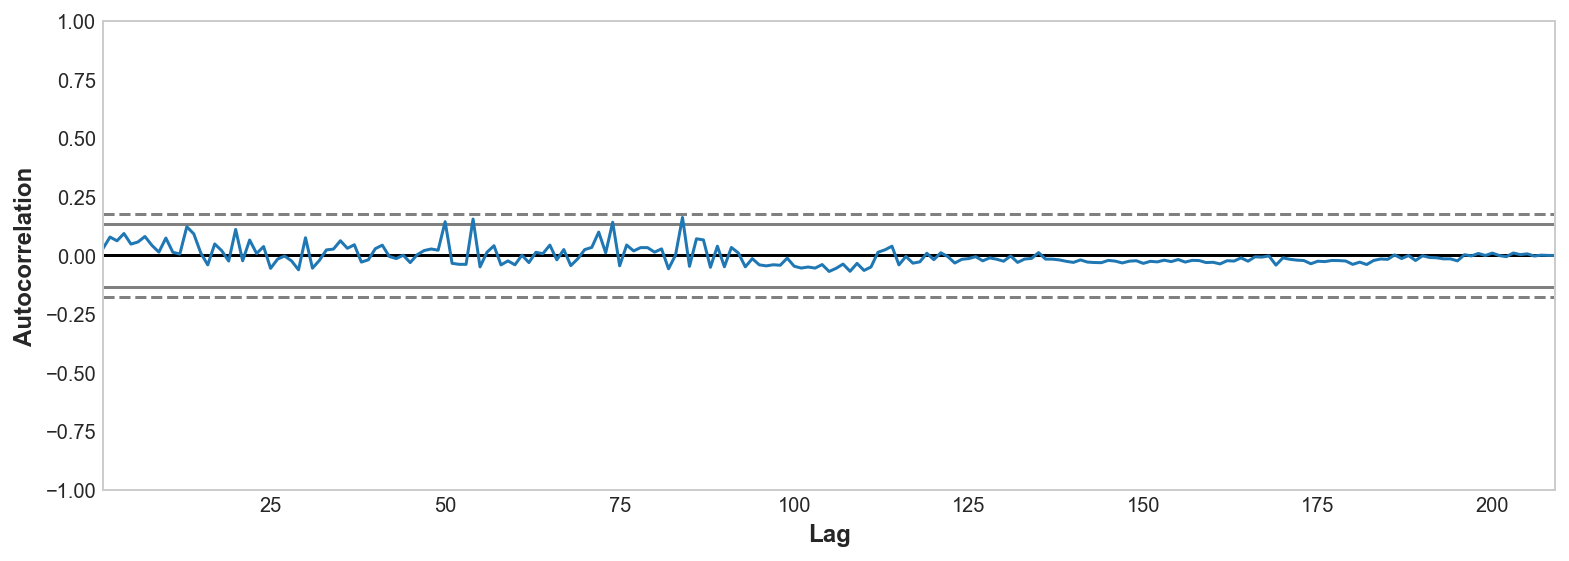

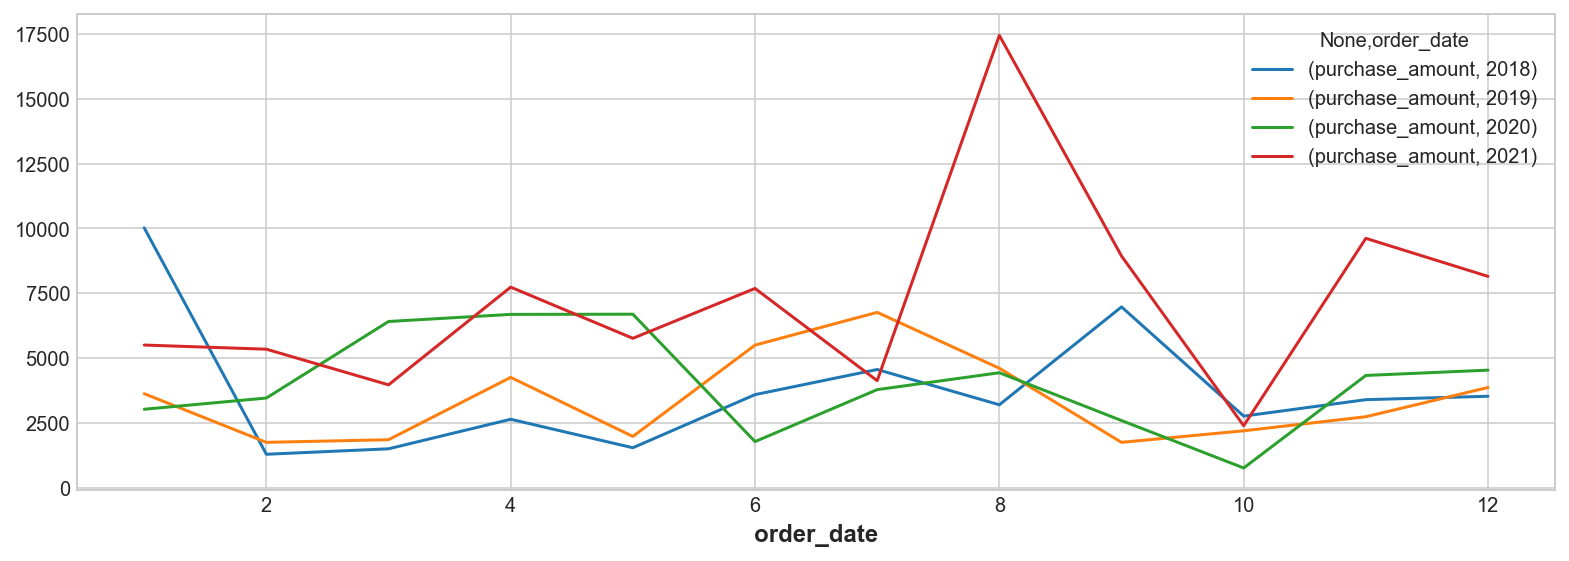

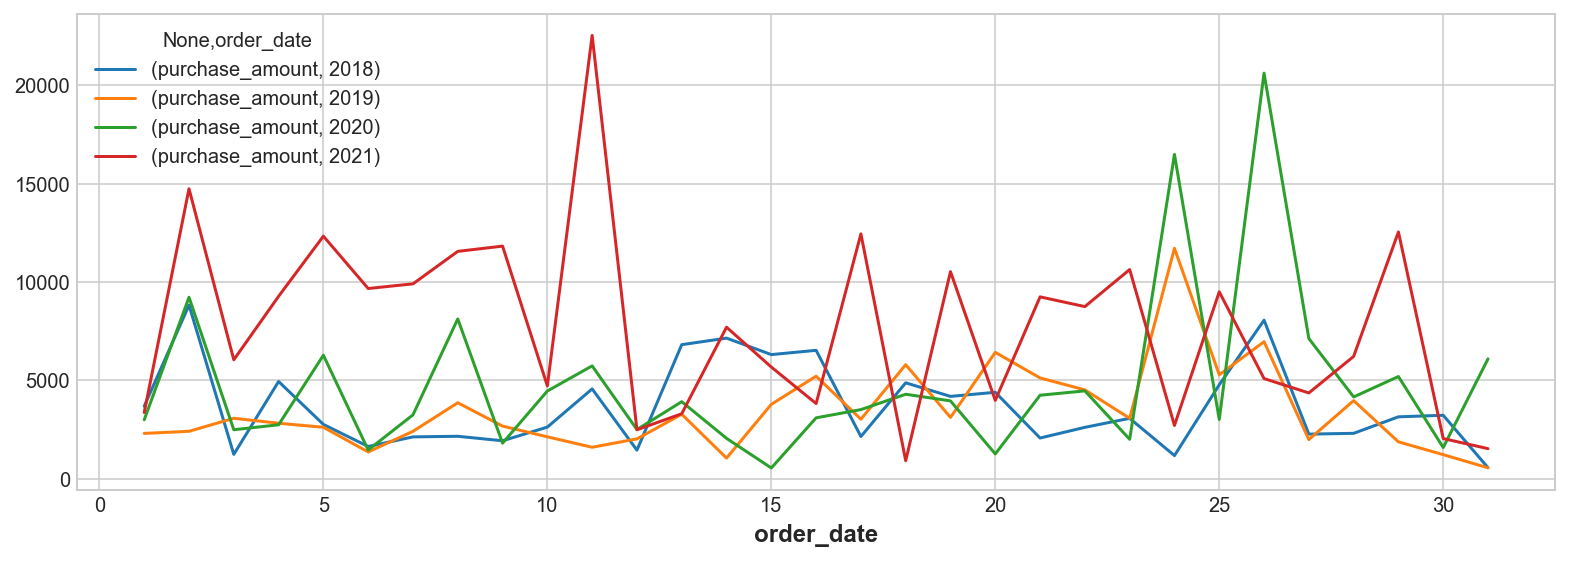

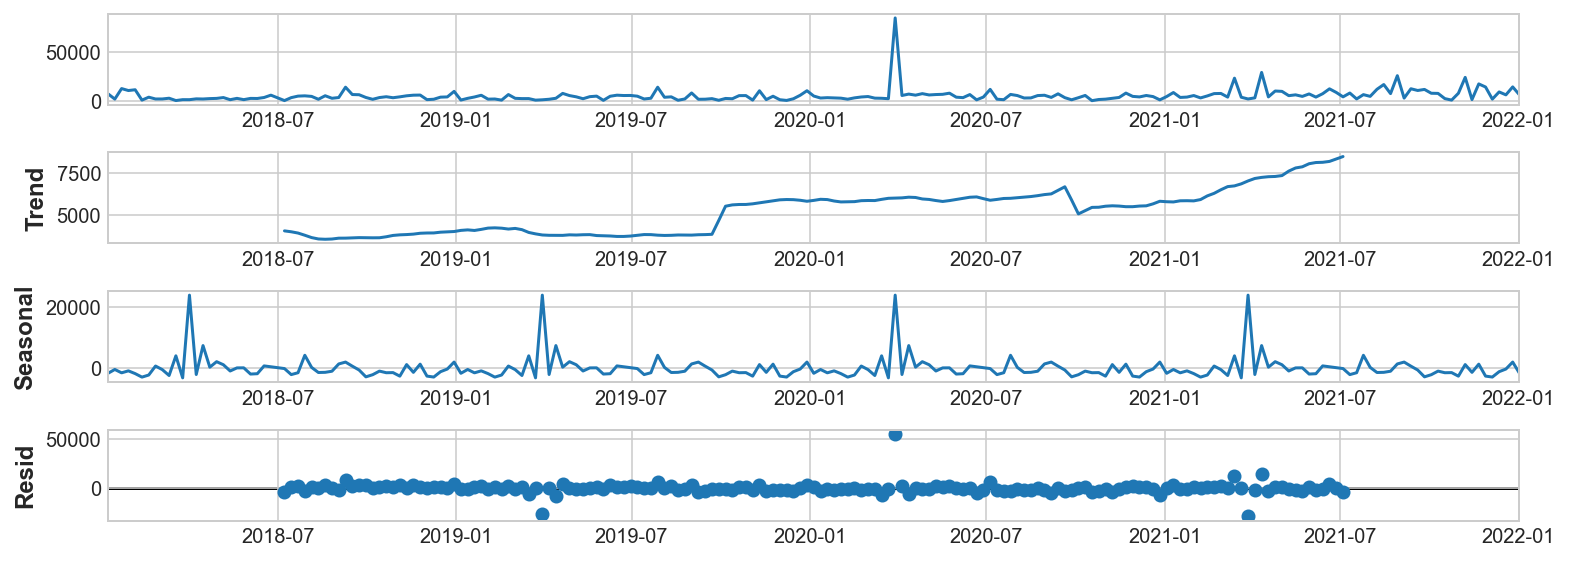

In [21]:
get_timeseries_plus(k_12)

In [22]:
su.get_customer_type_summary(train)

,total_purchase_amount,min_purchase_amount,max_purchase amount,average_purchase_amount,min_order_date,max_order_date,min_shipping_date,max_shipping_date
customer_type,,,,,,,,
Higher Ed,"200,305,221.56","-200,583.00","1,001,346.40","4,967.27",2018-01-02,2021-12-30,2018-01-05,2022-11-30
K-12,"298,079,471.56","-696,740.88","3,723,000.00","3,672.15",2018-01-02,2021-12-30,2018-01-02,2022-11-30
Local Government,"284,544,512.41","-468,750.00","2,028,000.00","3,937.73",2018-01-02,2021-12-31,2018-01-02,2022-11-30
Other,"1,918,628.88",-475.14,"101,420.58","3,579.53",2018-01-11,2021-12-22,2018-01-12,2022-02-28
State Agency,"171,212,339.55","-239,650.46","1,130,443.51","4,152.62",2018-01-05,2021-12-30,2018-01-11,2022-11-15


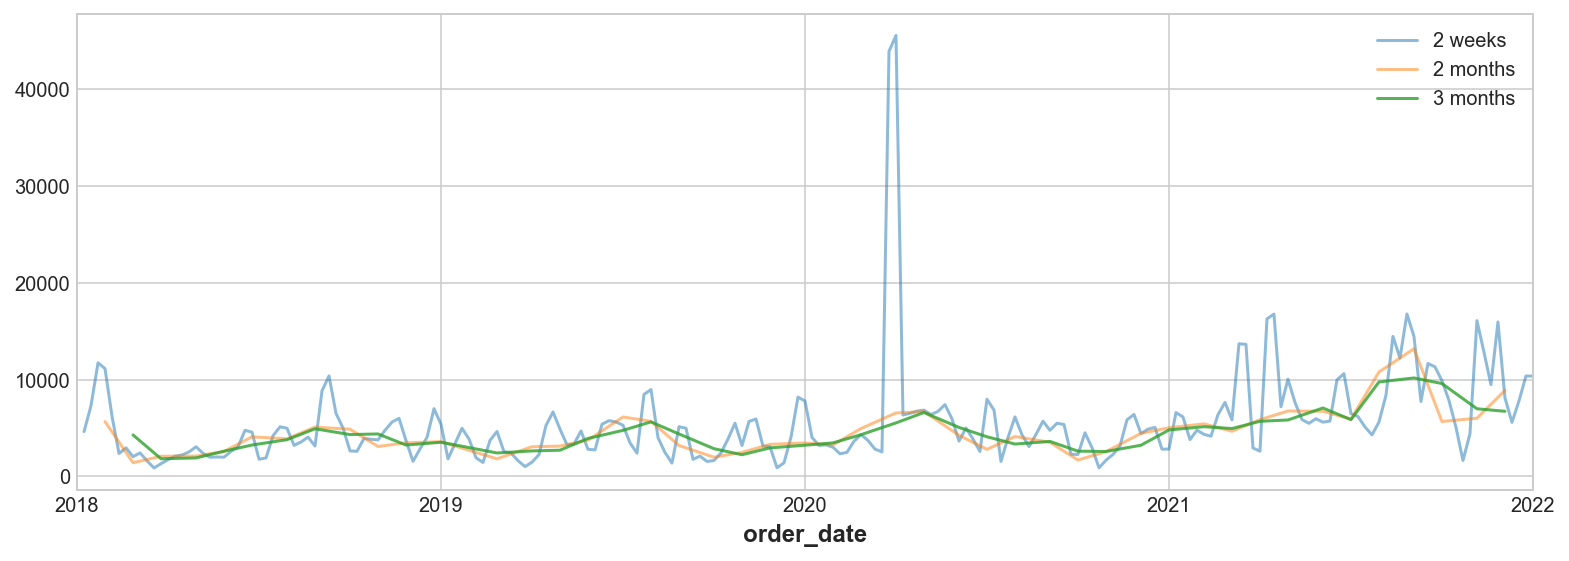

In [23]:
k_12.purchase_amount.resample('w').mean().rolling(2).mean().plot(alpha=.5, label='2 weeks')
k_12.purchase_amount.resample('m').mean().rolling(2).mean().plot(alpha=.5, label='2 months')
k_12.purchase_amount.resample('m').mean().rolling(3).mean().plot(alpha=.8, label='3 months')
#train.sales_total.resample('Y').mean().rolling(7).mean().plot(alpha=.8, label='1 Yearly')
plt.legend()

In [24]:
# resample by week 
y = train.purchase_amount.resample('W').mean()

# create decomposition object
decomposition = sm.tsa.seasonal_decompose(y)
decomposition
# make df
decomposition = pd.DataFrame({
    'y': decomposition.observed,
    'trend': decomposition.trend,
    'seasonal': decomposition.seasonal,
    'resid': decomposition.resid,
})
decomposition.head()

,y,trend,seasonal,resid
order_date,,,,
2018-01-07,"4,922.80",NaN,69.07,NaN
2018-01-14,"2,244.77",NaN,"-1,092.45",NaN
2018-01-21,"1,148.53",NaN,-249.04,NaN
2018-01-28,"7,466.56",NaN,"4,443.65",NaN
2018-02-04,"7,023.71",NaN,-491.30,NaN


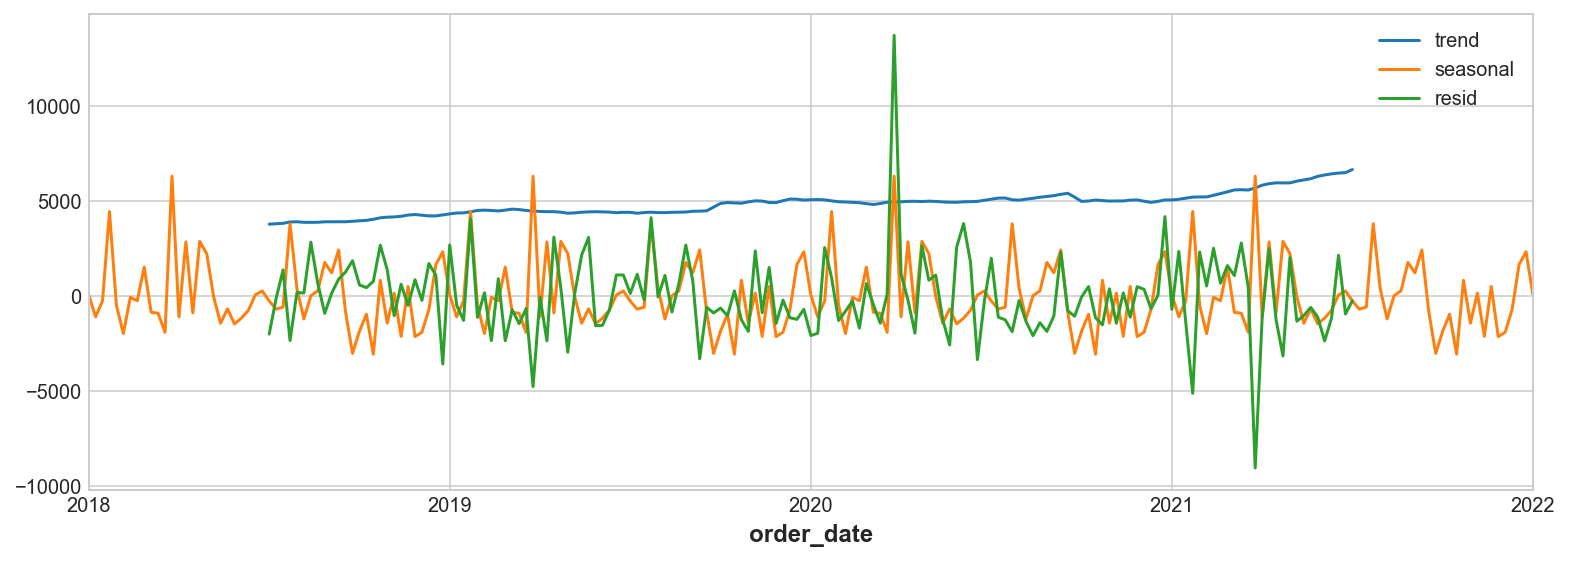

In [25]:
# plot using data frame
decomposition.iloc[:, 1:].plot();

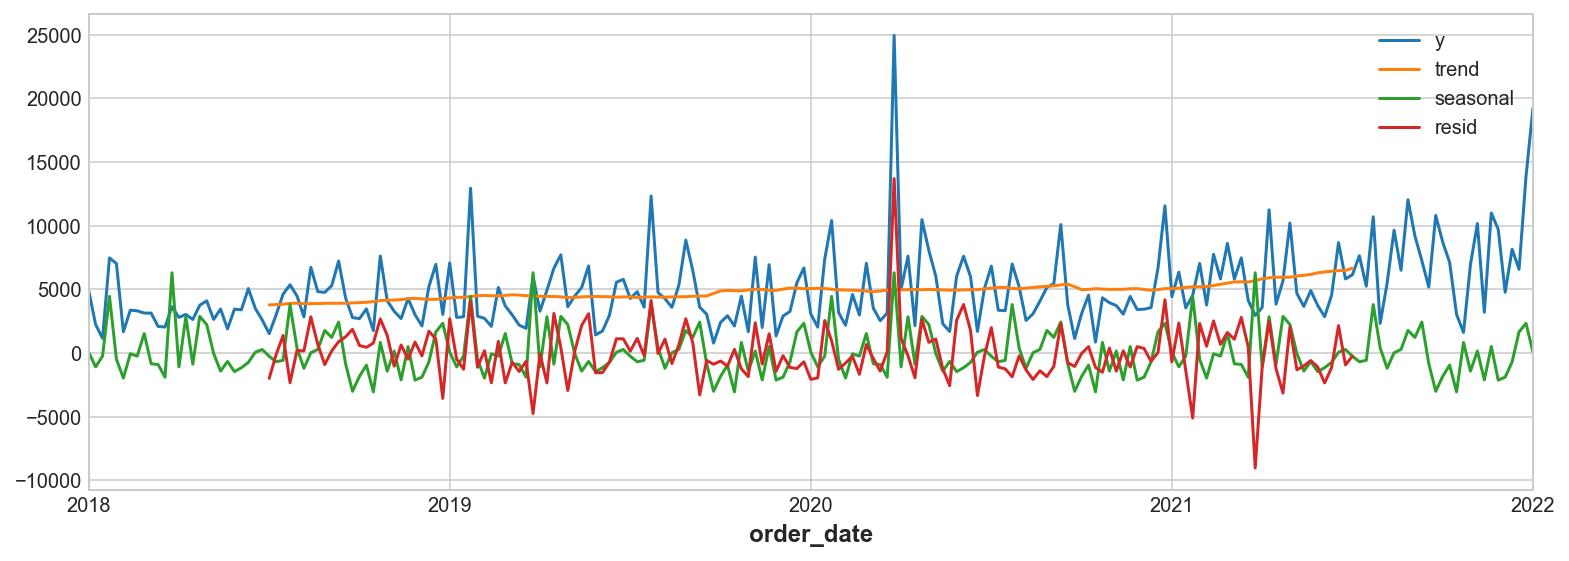

In [26]:
# the value returned from seasonal_decompose can itself be plotted:
decomposition.plot()
None

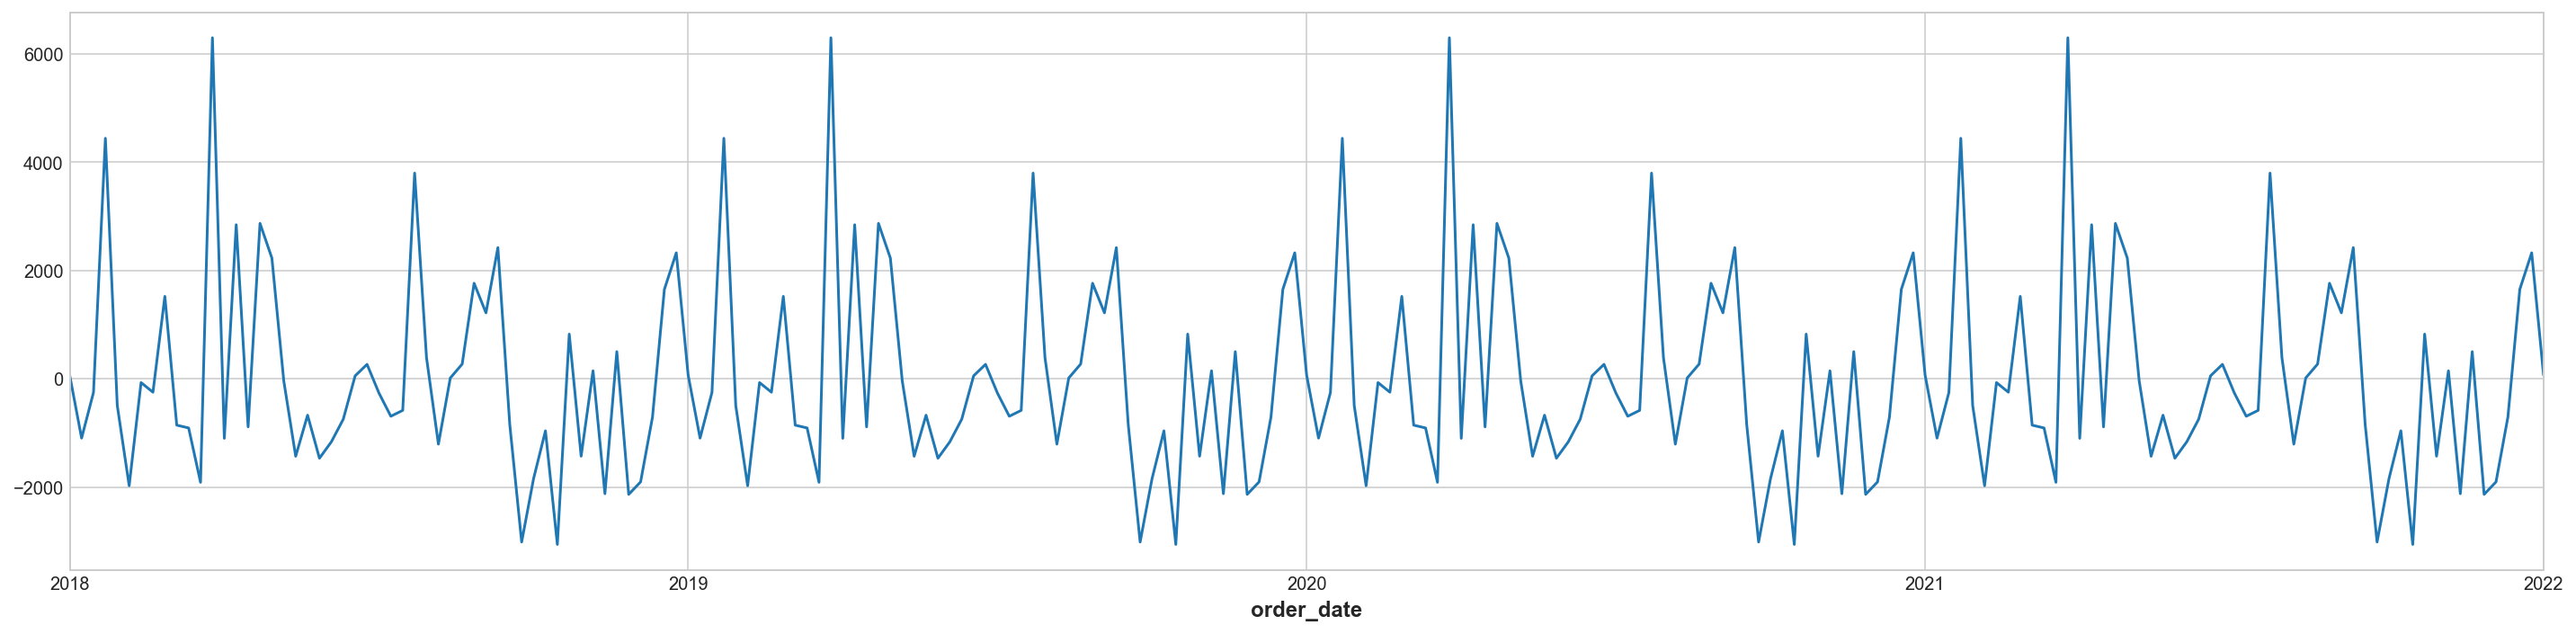

In [27]:
# plot decomposition seasonal
plt.figure(figsize =(20,5))
decomposition.seasonal.plot();

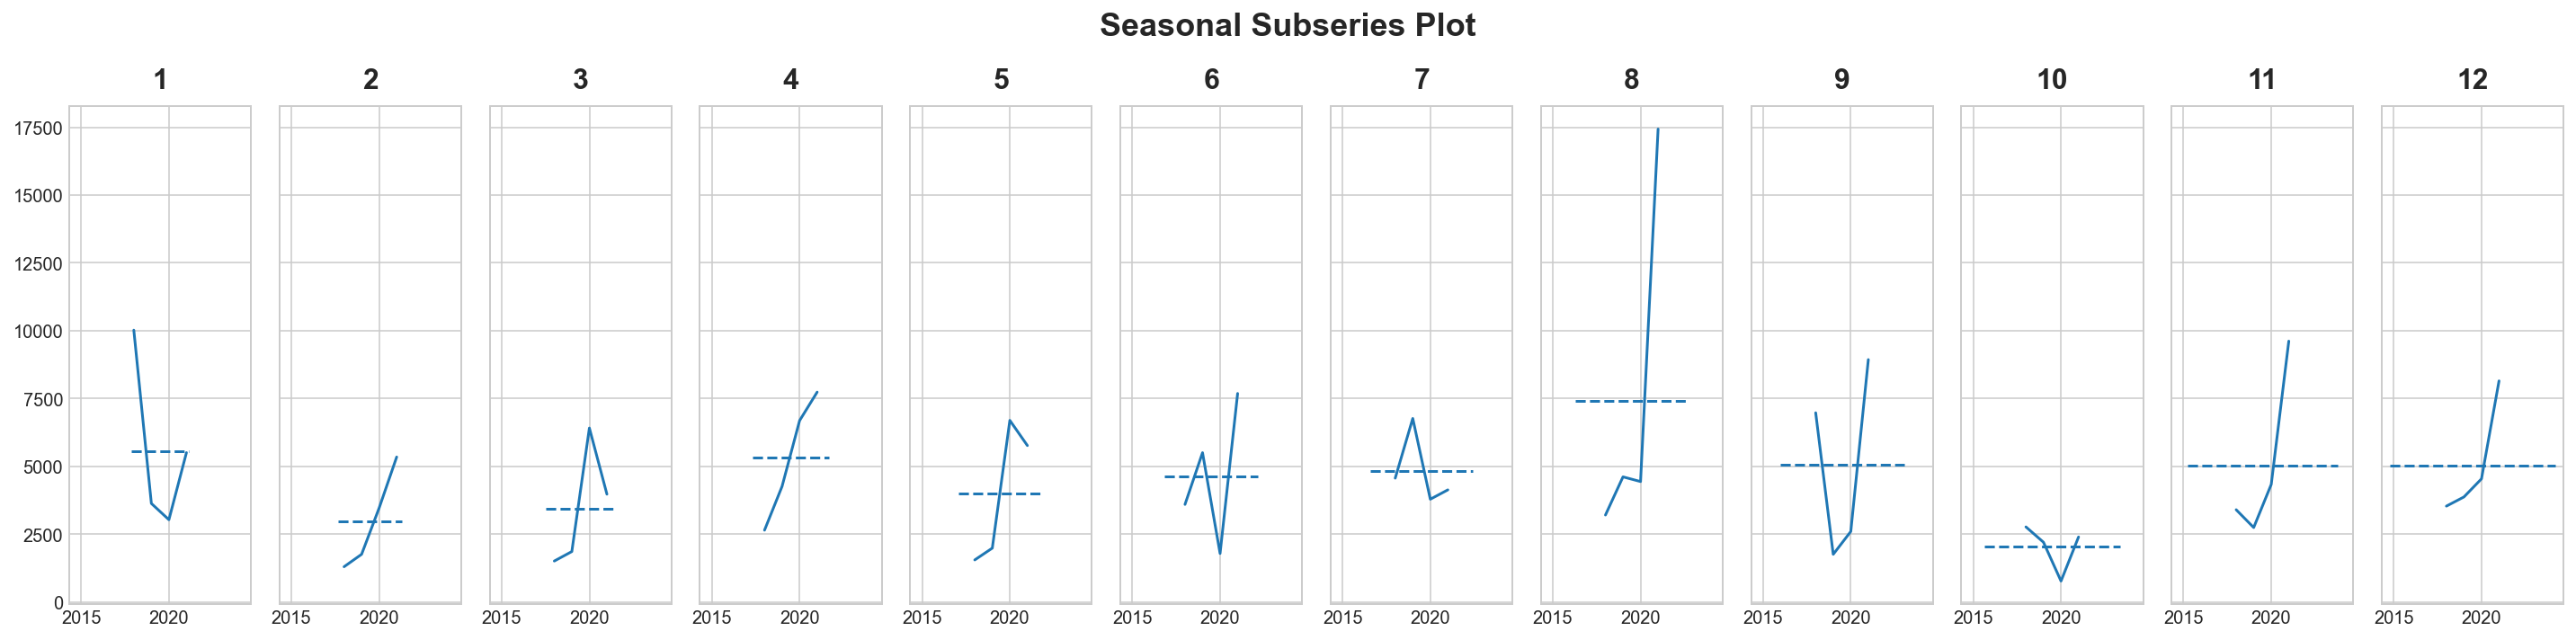

In [28]:
y = k_12.purchase_amount
y.head()
table = y.groupby([y.index.year, y.index.month]).mean().unstack()
table
fig, axs = plt.subplots(1, 12, sharey=True, sharex=True,figsize=(20, 5))

for ax, (month, subset) in zip(axs, table.iteritems()):
    subset.plot(ax=ax, title=month)
    x_left, x_right = ax.get_xlim()
    ax.hlines(subset.mean(), x_left, x_right, ls='--')
    ax.set(xlabel='')


fig.suptitle('Seasonal Subseries Plot') # super-title for the overall figure
fig.subplots_adjust(wspace=0)

### time series at a glance

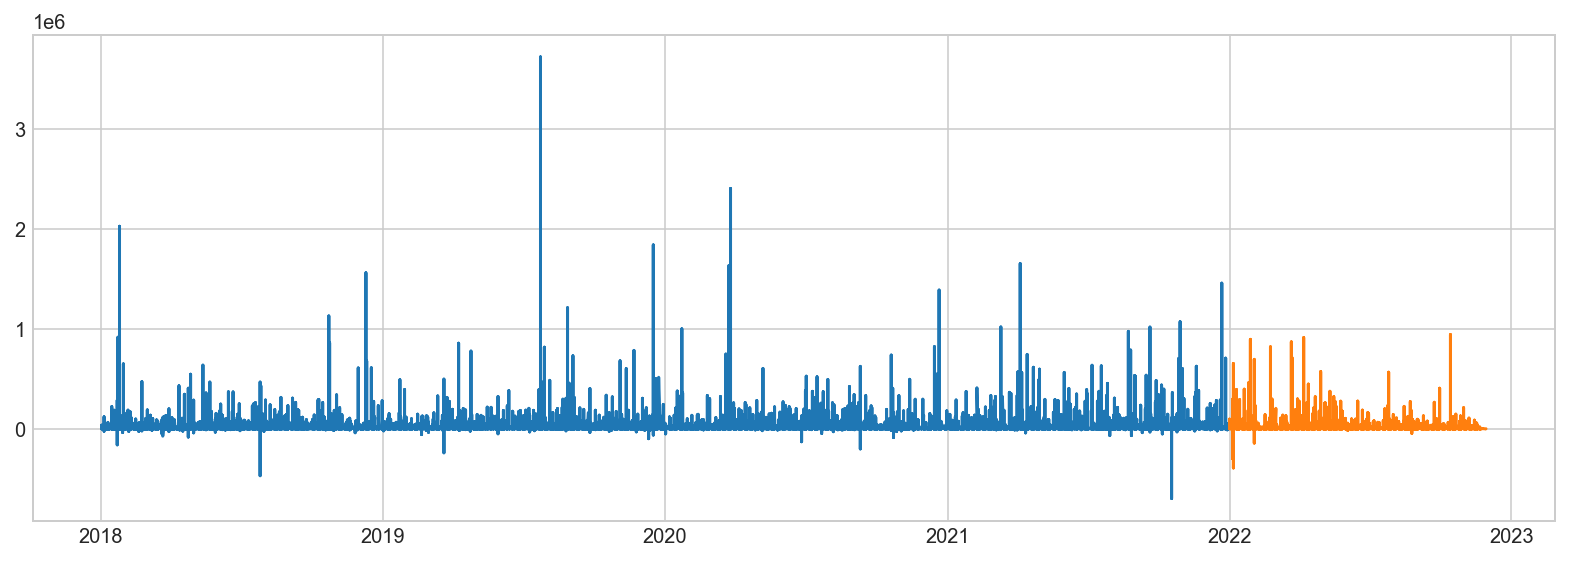

In [29]:
plt.plot(train.index, train.purchase_amount)
plt.plot(test.index, test.purchase_amount)

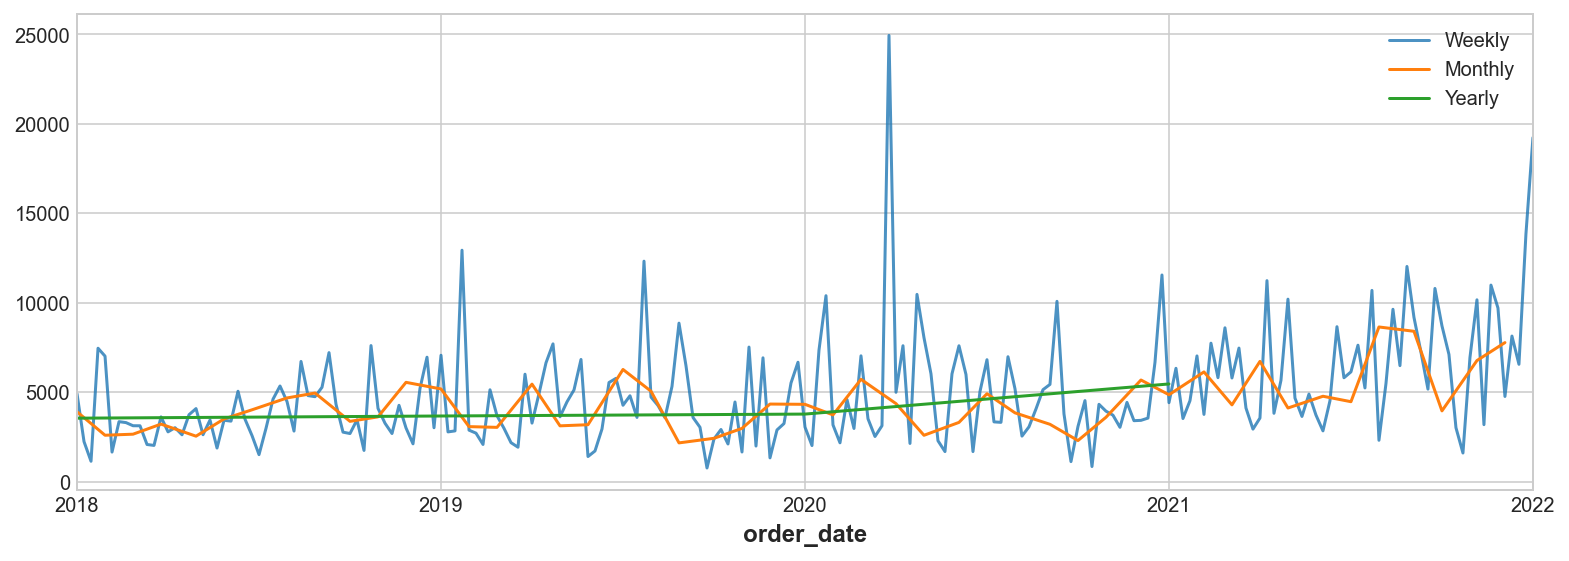

In [30]:
# resample with week , month, year
train.purchase_amount.resample('W').mean().plot(alpha=.8, label='Weekly')
train.purchase_amount.resample('M').mean().plot(label='Monthly')
train.purchase_amount.resample('Y').mean().plot(label='Yearly')
plt.legend()

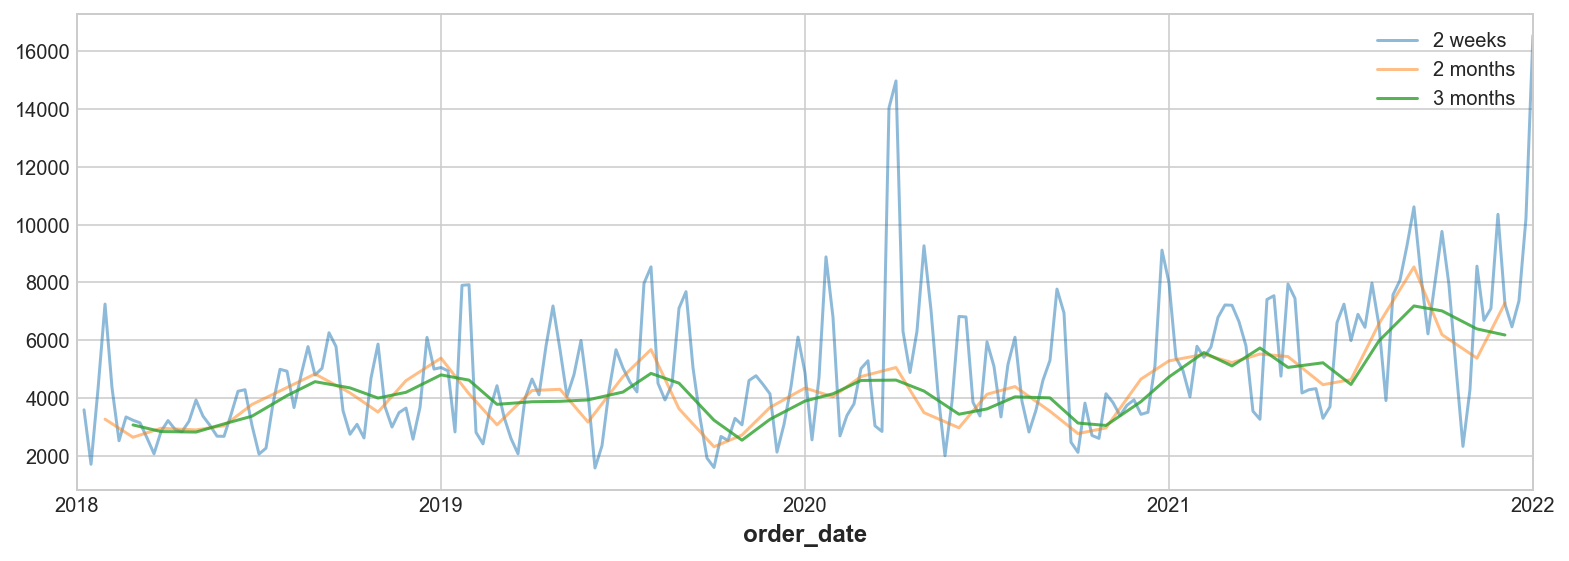

In [31]:
train.purchase_amount.resample('w').mean().rolling(2).mean().plot(alpha=.5, label='2 weeks')
train.purchase_amount.resample('m').mean().rolling(2).mean().plot(alpha=.5, label='2 months')
train.purchase_amount.resample('m').mean().rolling(3).mean().plot(alpha=.8, label='3 months')
#train.sales_total.resample('Y').mean().rolling(7).mean().plot(alpha=.8, label='1 Yearly')
plt.legend()

### diffirence

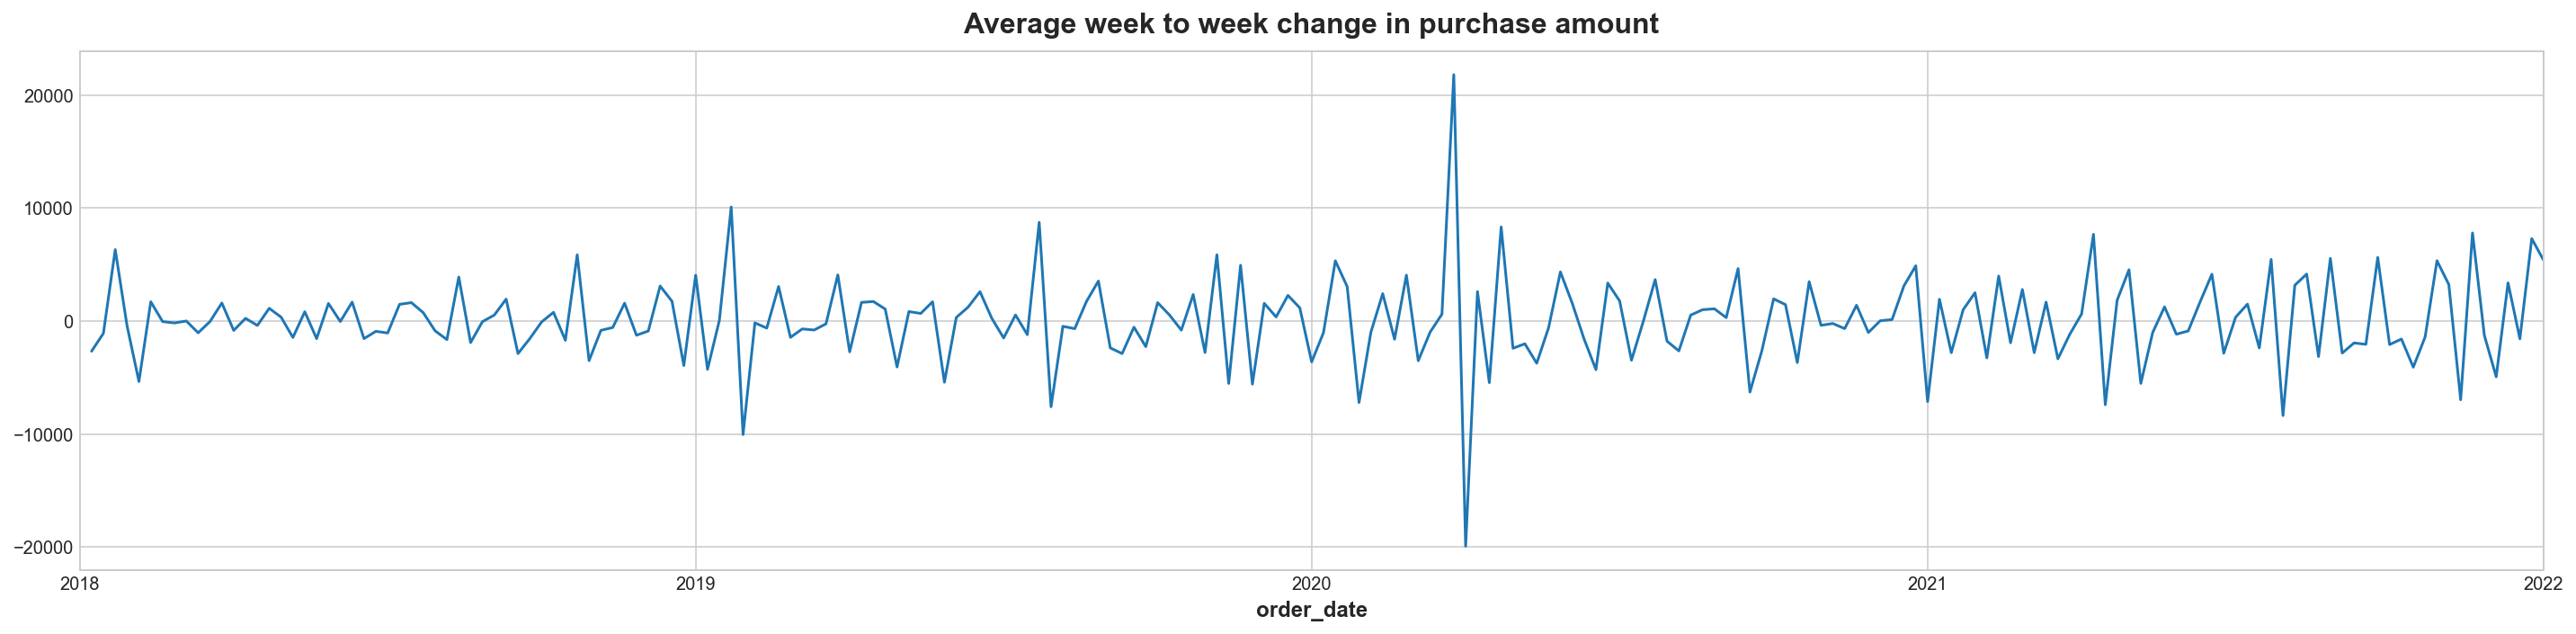

In [32]:
plt.figure(figsize =(20,5))
train.purchase_amount.resample('w').mean().diff().plot(title='Average week to week change in purchase amount');

### distribution of variables

In [33]:
def distribution( df, var):
    ''' distribution takes in a dataframe and variable and returns a histoplot 
    that  display the distirbution of the variable'''
    # use histplot
    sns.histplot(df[var])
    #show plot
    plt.show();


# Average purchased sales/order quantity by month and sum by month

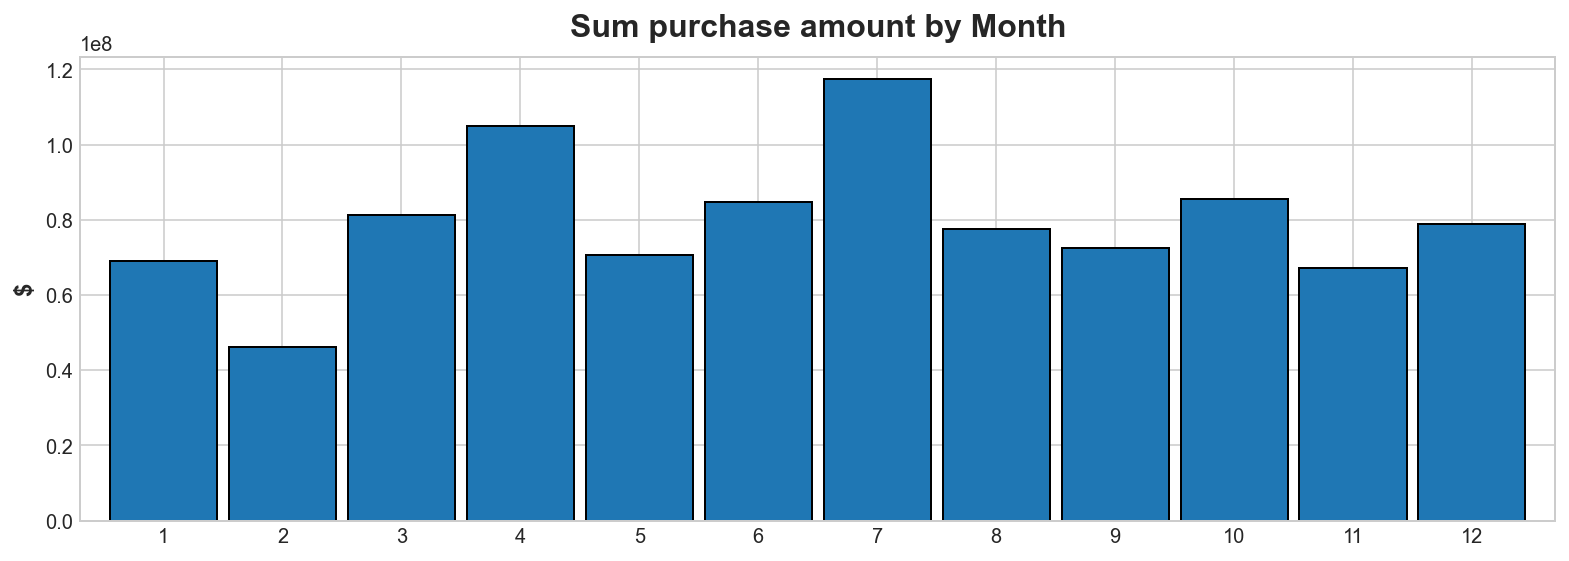

In [34]:
ax = train.groupby(train.month).purchase_amount.sum().plot.bar(width=.9, ec='black')
plt.xticks(rotation=0)
ax.set(title='Sum purchase amount by Month', xlabel='', ylabel='$')
plt.show()

### for total sales the month of July seems to be the largest next largest is to April

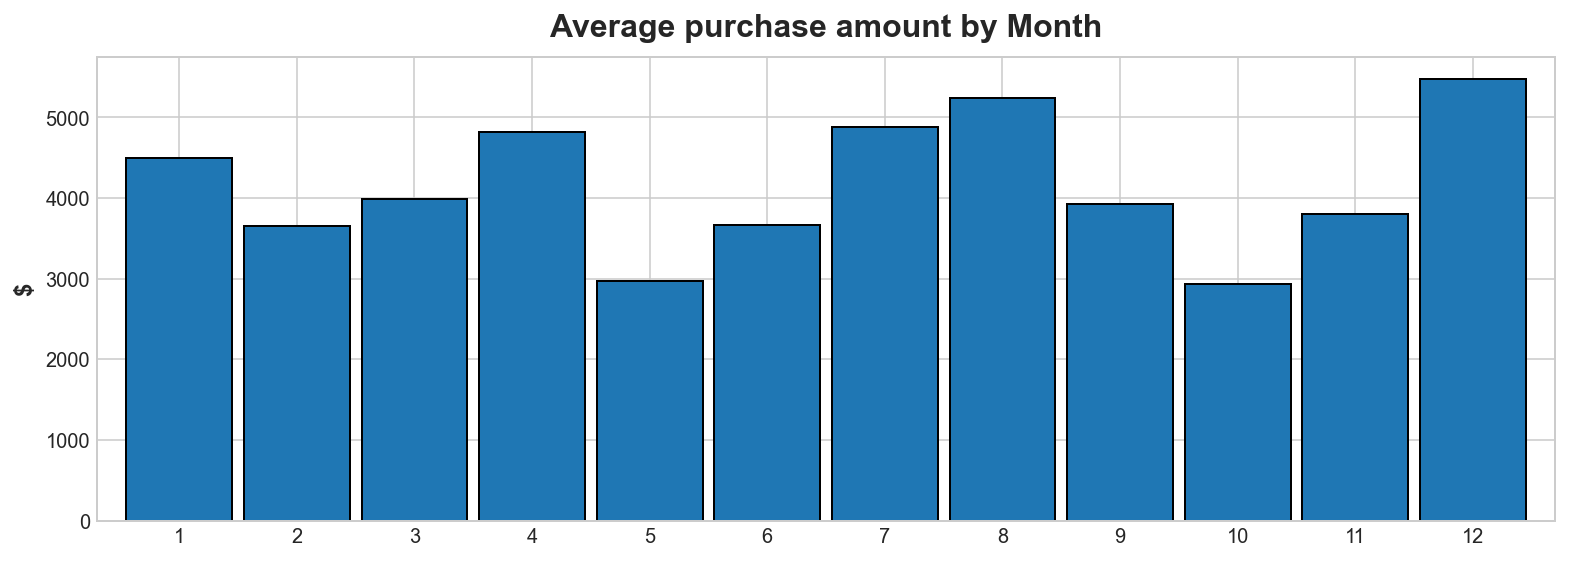

In [35]:
ax = train.groupby(train.month).purchase_amount.mean().plot.bar(width=.9, ec='black')
plt.xticks(rotation=0)
ax.set(title='Average purchase amount by Month', xlabel='', ylabel='$')
plt.show()

### for average sales december seems to have the most

In [36]:
train[['purchase_amount','month']].groupby('month').describe()

purchase_amount                                                        \
                count     mean       std         min    25%    50%      75%   
month                                                                         
1           15,353.00 4,501.10 26,726.87 -159,904.75 114.00 464.10 2,180.37   
2           12,622.00 3,659.97 14,038.05  -56,708.45 127.50 462.50 2,297.34   
3           20,383.00 3,993.43 31,228.95 -239,650.46 140.01 693.00 1,759.50   
4           21,777.00 4,815.56 25,708.28  -81,758.97  57.00 415.02 2,198.63   
5           23,786.00 2,969.91 13,080.03  -49,500.00 160.20 424.80 1,448.73   
6           23,142.00 3,667.21 16,114.96 -128,760.00 160.09 594.09 1,429.42   
7           24,050.00 4,885.26 33,522.87 -468,750.00 160.20 442.24 1,982.68   
8           14,771.00 5,246.79 24,767.81  -66,871.00 124.10 684.00 2,867.41   
9           18,491.00 3,922.11 20,330.56 -200,583.00  15.41 239.98 1,489.65   
10          29,116.00 2,936.35 19,064.97 -696,740.88  27.75 325.00 1,032.17   
11          17,629.00 3,803.82 20,459.49  -38,841.19 160.20 554.45 1,590.60   
12          14,405.00 5,478.41 34,613.85  -98,143.46  82.66 646.00 3,396.00   

                    
               max  
month               
1     2,028,000.00  
2       472,950.00  
3     2,406,064.50  
4     1,654,773.44  
5       638,297.40  
6       565,171.52  
7     3,723,000.00  
8     1,212,924.79  
9     1,019,084.75  
10    1,130,443.51  
11      785,353.20  
12    1,841,400.00

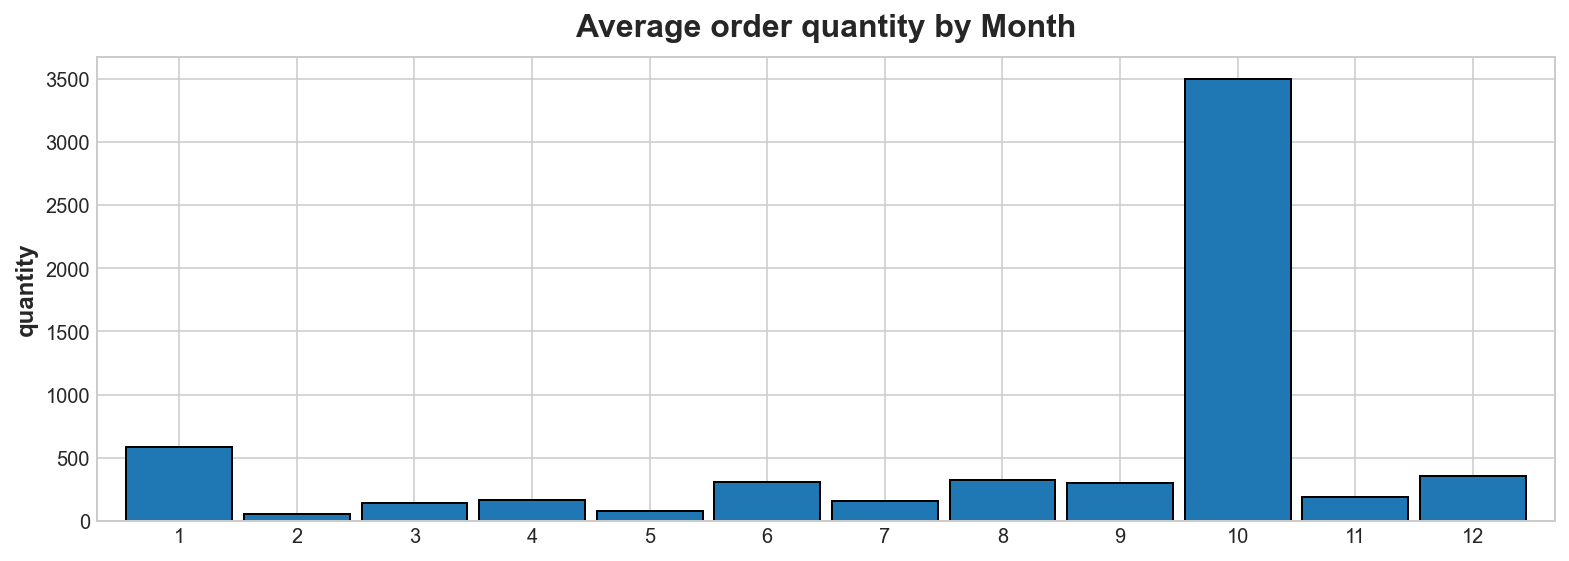

In [37]:
ax = train.groupby(train.month).order_quantity.mean().plot.bar(width=.9, ec='black')
plt.xticks(rotation=0)
ax.set(title='Average order quantity by Month', xlabel='', ylabel='quantity')
plt.show()

### October has  a huge spike in order quantity

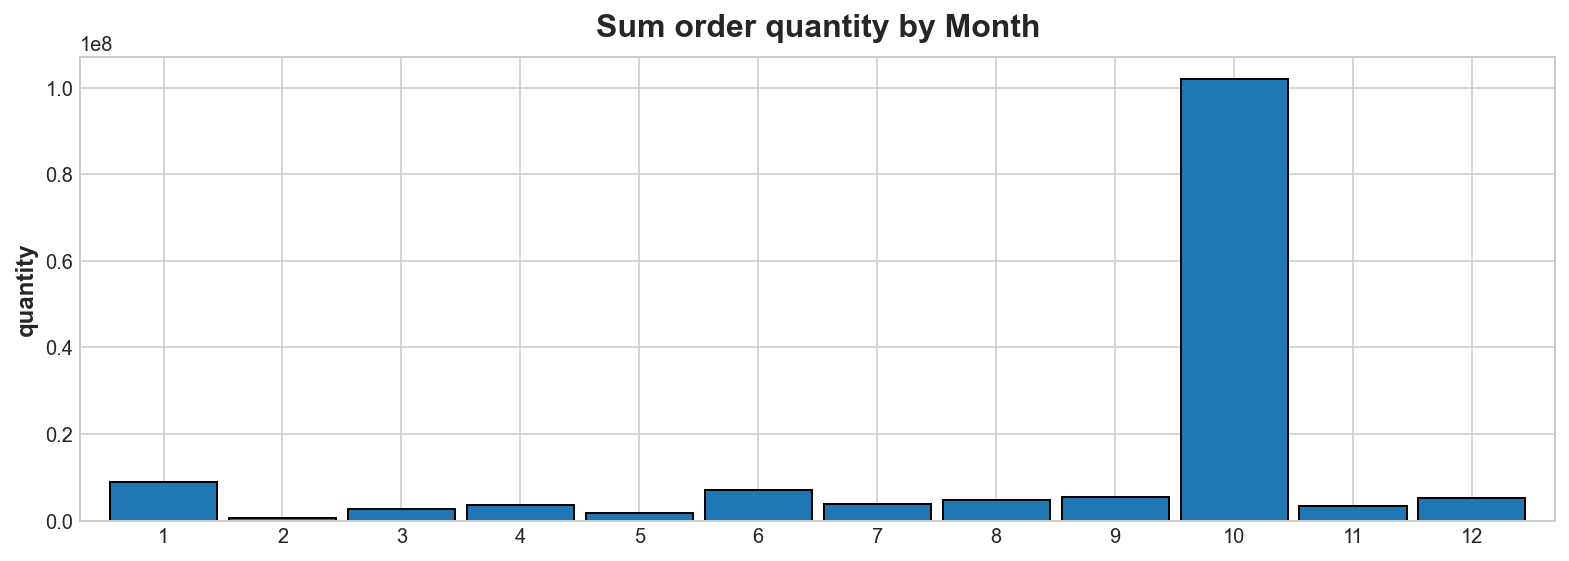

In [38]:
ax = train.groupby(train.month).order_quantity.sum().plot.bar(width=.9, ec='black')
plt.xticks(rotation=0)
ax.set(title='Sum order quantity by Month', xlabel='', ylabel='quantity')
plt.show()

In [39]:
train[['order_quantity','month']].groupby('month').describe()

order_quantity                                                   \
               count     mean        std           min  25%  50%  75%   
month                                                                   
1          15,353.00   582.98  32,133.43       -864.35 1.00 1.00 3.00   
2          12,622.00    53.32   1,413.36    -59,619.00 1.00 1.00 3.00   
3          20,383.00   136.22   2,854.13       -185.00 1.00 1.00 3.00   
4          21,777.00   166.88   3,177.14    -30,490.00 1.00 1.84 3.00   
5          23,786.00    76.32   3,294.61     -3,500.00 1.00 1.00 2.00   
6          23,142.00   302.74  13,894.78    -34,800.00 1.00 1.00 2.00   
7          24,050.00   157.93  11,171.84   -799,867.61 1.00 1.00 3.00   
8          14,771.00   320.21   9,318.62     -5,825.00 1.00 1.00 4.00   
9          18,491.00   300.60  19,334.38 -1,273,855.94 0.34 1.00 2.00   
10         29,116.00 3,503.36 551,516.31    -99,999.00 1.00 1.00 2.00   
11         17,629.00   188.10   7,428.31    -46,796.61 1.00 1.00 2.00   
12         14,405.00   356.03   7,686.24     -1,365.30 1.00 1.00 4.00   

                     
                max  
month                
1      3,767,123.29  
2         77,760.00  
3        183,296.80  
4        180,000.00  
5        468,750.00  
6      1,216,118.75  
7        799,867.61  
8        711,350.00  
9      1,273,855.94  
10    94,093,187.00  
11       884,747.26  
12       390,000.00

<AxesSubplot:xlabel='month', ylabel='purchase_amount'>

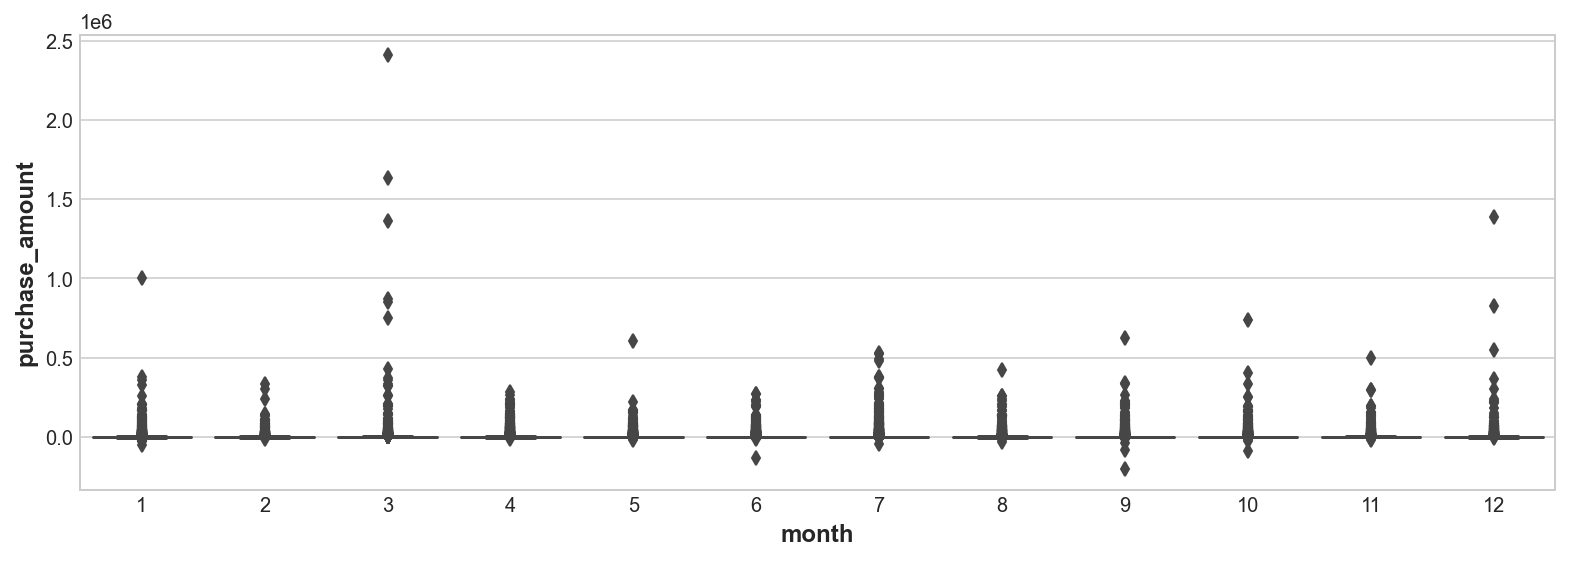

In [40]:
sns.boxplot(data = train['2020'], x = 'month', y = 'purchase_amount')

# Average purchased amount  by day

In [42]:
train.columns

Index(['customer_name', 'customer_type', 'customer_city', 'reseller_name',
       'reseller_city', 'customer_zip', 'order_quantity', 'unit_price',
       'po_number', 'shipped_date', 'order_date_copy', 'month_name',
       'day_name', 'year', 'quarter', 'month', 'week', 'day_of_week',
       'day_of_year', 'purchase_amount'],
      dtype='object')

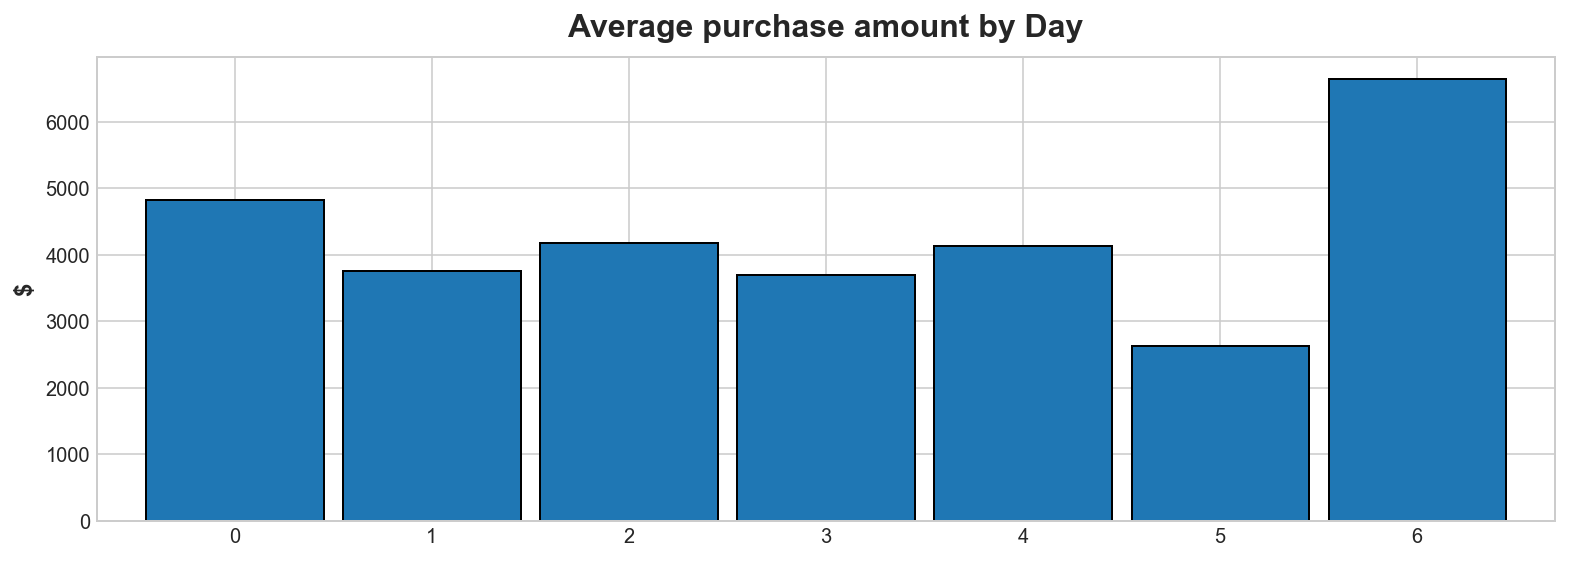

In [65]:
ax = train.groupby(train.day_of_week).purchase_amount.mean().plot.bar(width=.9, ec='black')
plt.xticks(rotation=0)
ax.set(title='Average purchase amount by Day', xlabel='', ylabel='$')
plt.show()

# customer types circle

In [ ]:
def viz_stroke_percentage(df):    
    fig, ax = plt.subplots(figsize=(9, 6),facecolor='floralwhite')

    sizes = np.array([len(df[df.stroke == 0]), len(df[df.stroke ==1])])
    labels = ["No Stroke", "Stroke Ocurred"]
    explode = [0.25,0 ]
    colors = ['#bad6eb', '#2b7bba']

    # Capture each of the return elements.
    patches, texts, pcts = ax.pie(
        sizes, labels=labels, autopct='%.2f%%', explode=explode,colors=colors,
        wedgeprops={'linewidth': 3.0, 'edgecolor': 'white'},
        textprops={'size': 16})
    # Style just the percent values.
    plt.setp(pcts, color='white', fontweight='bold')
    ax.set_title('Percent of patient who have suffer a stroke', fontsize=25,color='#0b559f')
    plt.tight_layout();

In [63]:
def viz_customer_types():
    '''
    the function creates a pie chart for customer types 
    '''
    piechart_labels = ['Local Governments','School Districts', 'Higher Education Institutions', 'State Agencies', 'Others']
    values = train.customer_type.value_counts(normalize=True).tolist()
    plt.figure(figsize=(8, 8))
    plt.pie(values, labels=piechart_labels,
            colors=sns.color_palette('accent'), autopct=autopct_format(values),
            shadow=False)
    plt.title('Customer types')
    plt.show()
    
def autopct_format(values):
    '''
    the function accept value_counts from outcome_type
    puts it in % format ready to use in pie charts
    '''
    def my_format(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        return '{:.1f}%)'.format(pct, v=val)
    return my_format
viz_customer_types()

ValueError: accent is not a valid palette name

<Figure size 576x576 with 0 Axes>

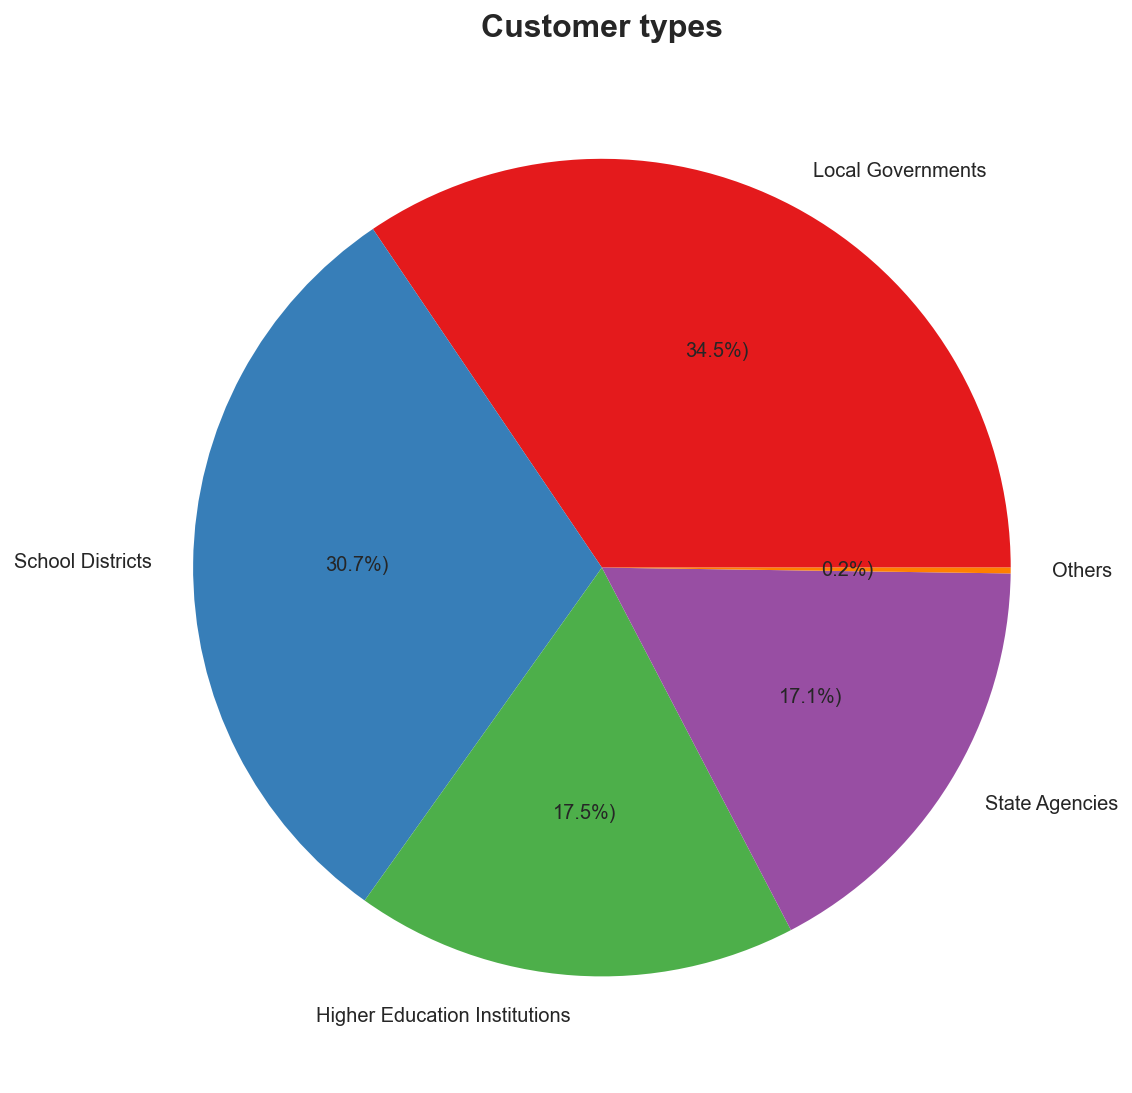

# Question look into 2017-07-24 the day with the largest sale

In [ ]:
sdf = su.get_summary_df(train)

In [ ]:
sdf

In [ ]:
sdf.loc['2019-07-24'].purchase_amount.sum()

In [ ]:
sdf.loc['2019-07-24'].groupby('customer_type').sum()

### there was a large sale done my the k-12 group

In [ ]:
k_12_max = train[(train.customer_type=='K-12')&(train.order_date_copy=='2019-07-24')]

In [ ]:
k_12_max.groupby('customer_name').sum()

In [ ]:
train.purchase_amount.idxmax()

# Question: look into the day with the largest order date...right before pandemic

In [ ]:
sdf2 = su.get_summary_df(train)

In [ ]:
sdf2.loc['2020-01-02']

In [ ]:
def get_summary_orders_df(df):
    '''
    Groups by order date, customer name, customer type, customer city and reseller name.
    Calculates the purchase amount by the end. of the day
    
    Parameters:
        df: pandas data frame with the data pulled from DIR site
    Returns:
        pd.DataFrame with the sum of the purchase amount by the end of the day for every company
    '''
    summary_df = pd.DataFrame()
    if 'order_date_copy' in df.columns:
        summary_df = df.groupby(by=\
                        ['order_date_copy', 'customer_name', 'customer_type', 'customer_city', 'reseller_name', 'shipped_date'])\
                        .order_quantity.sum().to_frame().reset_index()
        summary_df.rename(columns={'order_date_copy':'order_date'}, inplace=True)
        summary_df = summary_df.set_index('order_date').sort_index()
    elif 'order_date' in df.columns:
        summary_df = df.groupby(by=\
                        ['order_date', 'customer_name', 'customer_type', 'customer_city', 'reseller_name', 'shipped_date'])\
                        .purchase_amount.sum().to_frame().reset_index()
        summary_df = summary_df.set_index('order_date').sort_index()  
    return summary_df

In [ ]:
orders = get_summary_orders_df(train)

In [ ]:
orders.loc['2020-01-02']

# modeling prep

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import OneHotEncoder

In [ ]:

# we will have 2 different target variables 
dummies = pd.get_dummies(df['customer_type'], drop_first=False)

df = pd.concat([df, dummies], axis=1).drop(columns=['customer_type'])


### create model dataframe

In [ ]:
model_df = df[['purchase_amount','']]

In [ ]:
df.purchase_amount.plot(figsize=(12,8))

In [ ]:
model_df_weekly= model_df.resample("D").mean()

In [ ]:
model_df_weekly.plot(figsize=(12,8));

In [ ]:
model_df_weekly

In [ ]:
model_df_weekly['sale_last_week'] = model_df_weekly['purchase_amount'].shift(1)
model_df_weekly['sale_2weeks_back'] = model_df_weekly.purchase_amount.shift(2)
model_df_weekly['sale_3weeks_back'] = model_df_weekly.purchase_amount.shift(3)

In [ ]:
# train
#model_df_weekly[3:-101]
# validate
#model_df_weekly["2021"]
# test
#model_df_weekly[-49:]

In [ ]:
model_df_weekly

In [ ]:
lin_model = LinearRegression()
model = RandomForestRegressor(max_depth=50, max_features='sqrt', min_samples_leaf=4,
                      min_samples_split=10, n_estimators=400, random_state=123)

In [ ]:
train.shape

### split for train test

In [ ]:
train, test = wr.split_data(df)
validate = test.loc[:'2022-06'].copy() 
test = test.loc['2022-07':].copy()

In [ ]:
train.shape, validate.shape, test.shape

In [ ]:
train.customer_type

In [ ]:
y=np.array(model_df_weekly.purchase_amount)
x1,x2,x3 = np.array(model_df_weekly.sale_last_week), np.array(model_df_weekly.sale_2weeks_back), np.array(model_df_weekly.sale_3weeks_back)

In [ ]:
final_x = np.concatenate((x1,x2,x3), axis = 1)


In [ ]:
# modeling
X_train, y_train, X_test, y_test = m.modeling_preprocessing(df, columns_to_keep=['customer_type', 'month_name','day_name', 'quarter'], regression=False, np_array=False)

In [ ]:
# cut off all null values start train at index 3
X_train, X_val, X_test, y_train,y_val, y_test = final_x[3:-101],final_x[-101:-49],final_x[-49:], y[3:-101],y[-101:-49],y[-49:]

In [ ]:
X_train

In [ ]:
ohe = OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False).fit(X_train)
X_train = ohe.transform(X_train)
X_test = ohe.transform(X_test)

In [ ]:
# random Forest
model.fit(X_train, y_train)
# linear regression
lin_model.fit(X_train,y_train)

In [ ]:
pred=model.predict(X_test)
plt.plot(pred, label = 'Random Forest Predictions')
plt.plot(y_test, label='Actual sales')
plt.legend(loc = 'upper left')
plt.show()

In [ ]:
# RMSE
rmse_randomforest= sqrt(mean_squared_error(pred, y_test))
rmse_randomforest

In [ ]:
lin_pred=lin_model.predict(X_test)
plt.plot(lin_pred, label = 'Random Forest Predictions')
plt.plot(y_test, label='Actual sales')
plt.legend(loc = 'upper left')
plt.show()

In [ ]:
# RMSE
rmse_linear= sqrt(mean_squared_error(lin_pred, y_test))
rmse_linear

### with grid search

In [ ]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

In [ ]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train,y_train)

In [ ]:
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    mape = 100 * np.mean(errors / test_labels)
    accuracy = 100 - mape
    print('Model Performance')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    
    return accuracy
base_model = RandomForestRegressor(n_estimators = 10, random_state = 42)
base_model.fit(X_train, y_train)


In [ ]:
best_random = rf_random.best_estimator_

best_random



```python 
RandomForestRegressor(max_depth=50, max_features='sqrt', min_samples_leaf=4,
                      min_samples_split=10, n_estimators=800)
```

### find best for linear

In [ ]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor

In [ ]:
GBR = GradientBoostingRegressor()

In [ ]:
parameters = {'learning_rate': [0.01,0.02,0.03,0.04],
              'subsample'    : [0.9, 0.5, 0.2, 0.1],
              'n_estimators' : [100,500,1000, 1500],
              'max_depth'    : [4,6,8,10]
             }

In [ ]:
grid_GBR = GridSearchCV(estimator=GBR, param_grid = parameters, cv = 2, n_jobs=-1)
grid_GBR.fit(X_train, y_train)

In [ ]:
print(" Results from Grid Search " )
print("\n The best estimator across ALL searched params:\n",grid_GBR.best_estimator_)
print("\n The best score across ALL searched params:\n",grid_GBR.best_score_)
print("\n The best parameters across ALL searched params:\n",grid_GBR.best_params_)

In [ ]:
grid_GBR_pred=grid_GBR.predict(X_val)
plt.plot(grid_GBR_pred, label = 'Predictions')
plt.plot(y_val, label='Actual sales')
plt.legend(loc = 'upper left')
plt.show()

In [ ]:
rmse_linear= sqrt(mean_squared_error(grid_GBR_pred, y_val))
rmse_linear

In [ ]:
import xgboost
print(xgboost.__version__)